# Minimal Edit Reclassification

Imagine you have two groups, disease-state cases and healthy controls. We want to treat the cases such that all of the cases become indistinguishable from healthy controls

Let's also assume that we have metadata for these groups. This data may be predictive of outcomes, and may even contain measurements of the root-cause variable, which is currently unknown.

If we have more information than we can make sense of manually, we can utilize dimensionality reduction followed by clustering to re-discover the groupings.

If we are able to cleanly differentiate between groups in this lower-dimension space, then we can feel confident that we have measured variables that are predictive of grouping status.

Since we don't know what the root-cause of the difference between the groups is, but we do have information that can predict groups, we can simply try to modify the original variables stepwise until the cases become indistinguishable from the controls. In this situation, we haven't necessarily determined the root-issue, but we may have sufficiently perturbed the system to alleviate the phenotype of concern. If this perturbation stabilizes naturally, then we have cured the disease. If the modifications are not sufficient to cure the disease, additional changes can be made step-wise until the phenotypic change is acheived or until we exhaust all of our current hypotheses.

Given a finite set of hypotheses and variables, this should converge on the minimum number of changes that are both necessary and sufficient to successfully treat the disease. Finding the minimum number of changes that are both necessary and sufficient to treat the disease can also be used to guide the discovery of the root-cause of the disease.

This method can be utilized on a case-by-case basis, enabling a personalized and precise treatment. If individualized treatment regiments are not possible, a generalized treatment that works well throughout the cohort can also be developed by averaging across individuals.

In [ ]:
DATE = "2021-10-02"
TASK = "minimum-necessary-changes"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)");

In [2]:
import Pkg
pkgs = [
    "BioAlignments",
    "BioSequences",
    "Clustering",
    "CodecZlib",
#     "Colors",
#     "Combinatorics",
    "DataFrames",
    "DataStructures",
    "Dates",
#     "DelimitedFiles",
    "Distances",
    "Distributions",
#     "EzXML",
    "FASTX",
#     "GFF3",
    "GLM",
    "GraphPlot",
#     "HTTP",
#     "Impute",
#     "JSON",
    "Graphs",
    "LsqFit",
#     "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
    "MultivariateStats",
#     "NumericIO",
    "OnlineStats",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
    "StatsPlots",
#     "StringDistances",
    "uCSV",
#     "XLSX",
    "RollingFunctions",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [7]:
# StatsPlots.plotlyjs()
StatsPlots.gr();

Here we perform dimensionality reduction with PCA and transform the raw data into this lower dimensional space

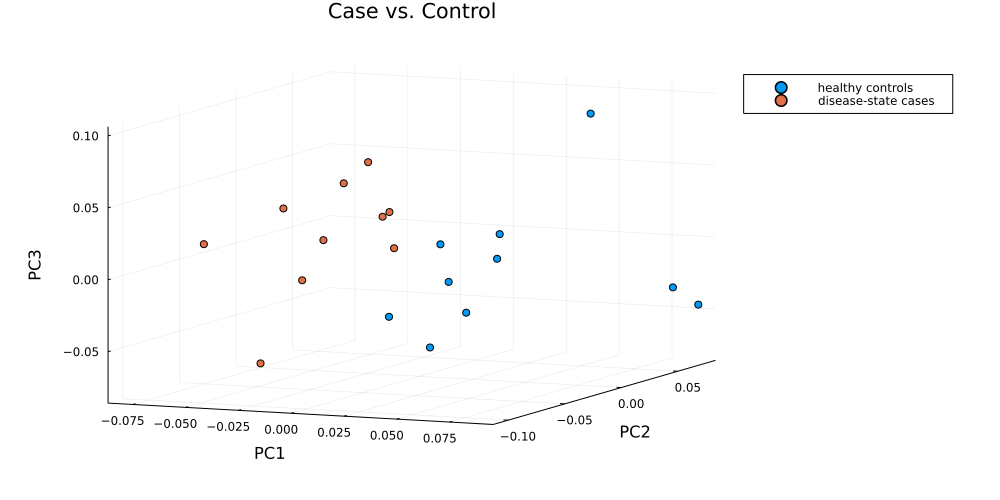

In [10]:
number_of_groups = 2
variables_per_group = 100
samples_per_group = 10
Random.seed!(number_of_groups * variables_per_group * samples_per_group)
group_distributions = [
        Distributions.Dirichlet(rand(variables_per_group)) for i in 1:number_of_groups
]
observations = reduce(hcat, [rand(gd, samples_per_group) for gd in group_distributions])
pca_model = MultivariateStats.fit(MultivariateStats.PCA, observations)


# principalvars = MultivariateStats.principalvars(pca_model)
# percent_variance = principalvars ./ sum(principalvars)
# p = StatsPlots.scatter(
#     accumulate(+, percent_variance),
#     title = "Model Variance",
#     legend = false,
#     xlabel = "Principle Components",
#     ylabel = "Variance Captured"
# )
# display(p)


transformed_observations = MultivariateStats.transform(pca_model, observations)

x = transformed_observations[1, :]
y = transformed_observations[2, :]
z = transformed_observations[3, :]

pc3_plot = 
StatsPlots.scatter(
    [x[1:samples_per_group], x[samples_per_group+1:end]],
    [y[1:samples_per_group], y[samples_per_group+1:end]],
    [z[1:samples_per_group], z[samples_per_group+1:end]],
    xlabel = "PC1",
    ylabel = "PC2",
    zlabel = "PC3",
    labels = ["healthy controls" "disease-state cases"],
    title = "Case vs. Control",
    legend = :outertopright,
    size = (1000, 500),
    margins = 1StatsPlots.cm,
)

# pc2_plot = 
# StatsPlots.scatter(
#     [x[1:samples_per_group], x[samples_per_group+1:end]],
#     [y[1:samples_per_group], y[samples_per_group+1:end]],
#     xlabel = "PC1",
#     ylabel = "PC2",
# )
# display(pc2_plot)
display(pc3_plot)

Here we determine the centroids of the "average case" and the "average" control

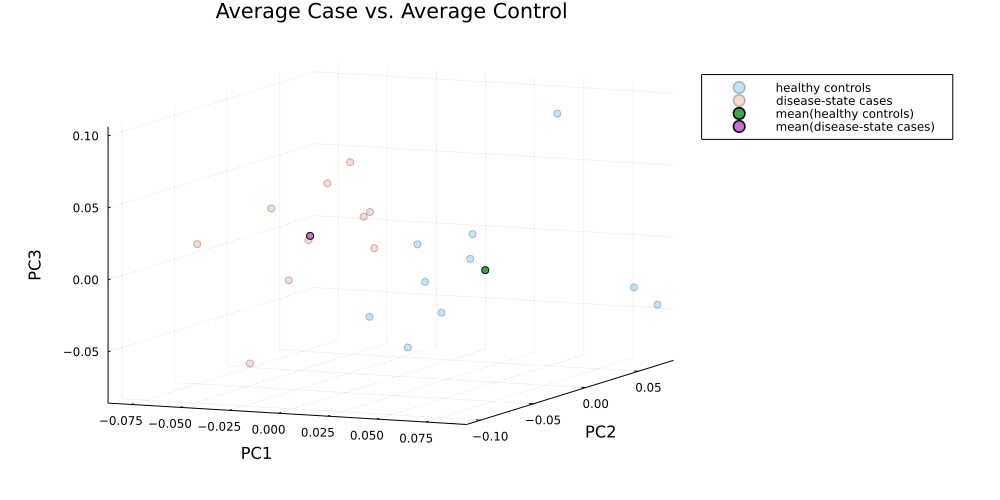

In [5]:
mean_of_transformed_controls = Statistics.mean(transformed_observations[:, 1:samples_per_group], dims=2)
mean_of_transformed_cases = Statistics.mean(transformed_observations[:, samples_per_group+1:end], dims=2)

# transform midpiont back to original dimensions
reconstructed_mean_of_controls = MultivariateStats.reconstruct(pca_model, mean_of_transformed_controls)
reconstructed_mean_of_cases = MultivariateStats.reconstruct(pca_model, mean_of_transformed_cases)

xs = [
    x[1:samples_per_group],
    x[samples_per_group+1:end],
    mean_of_transformed_controls[1:1],
    mean_of_transformed_cases[1:1]
]

ys = [
    y[1:samples_per_group],
    y[samples_per_group+1:end],
    mean_of_transformed_controls[2:2],
    mean_of_transformed_cases[2:2]
]

zs = [
    z[1:samples_per_group],
    z[samples_per_group+1:end],
    mean_of_transformed_controls[3:3],
    mean_of_transformed_cases[3:3]
]

labels = [
    "healthy controls",
    "disease-state cases",
    "mean(healthy controls)",
    "mean(disease-state cases)"
]

pc3_plot = 
StatsPlots.scatter(
    xs,
    ys,
    zs,
    xlabel = "PC1",
    ylabel = "PC2",
    zlabel = "PC3",
    legend = :outertopright,
    labels = hcat(labels...),
    size = (1000, 500),
    margins = 1StatsPlots.cm,
    alpha = [0.25 0.25 1.0 1.0],
    title = "Average Case vs. Average Control"
)

And finally, we determine the fewest number of transformations to observed variables that, if made, would make the case more like the average healthy control than the average disease-state case

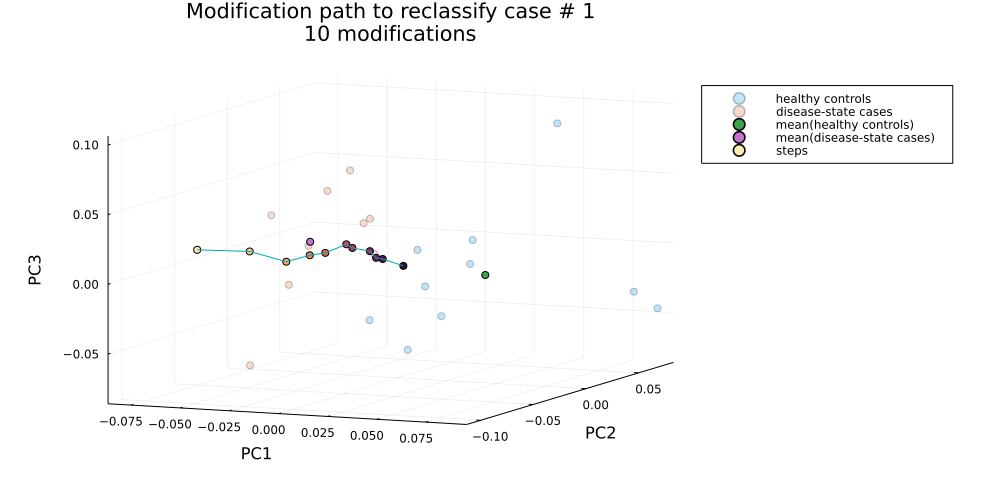

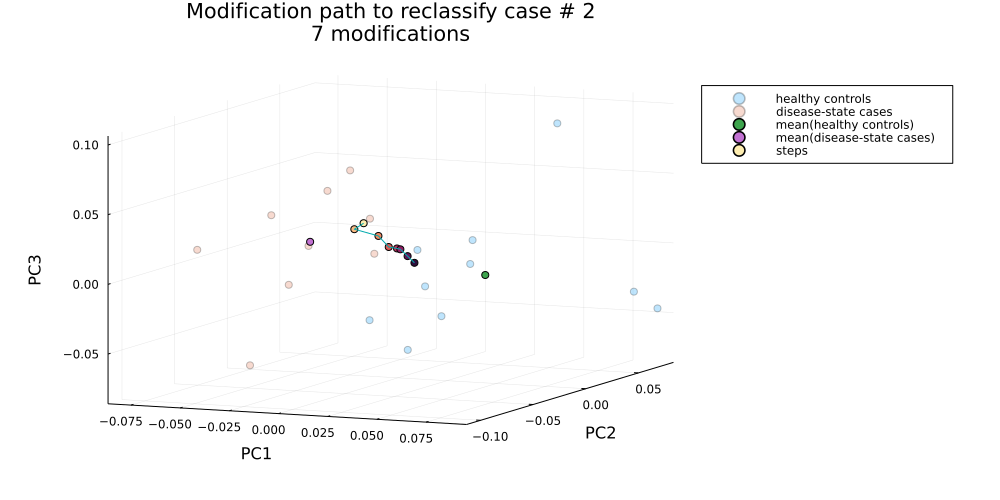

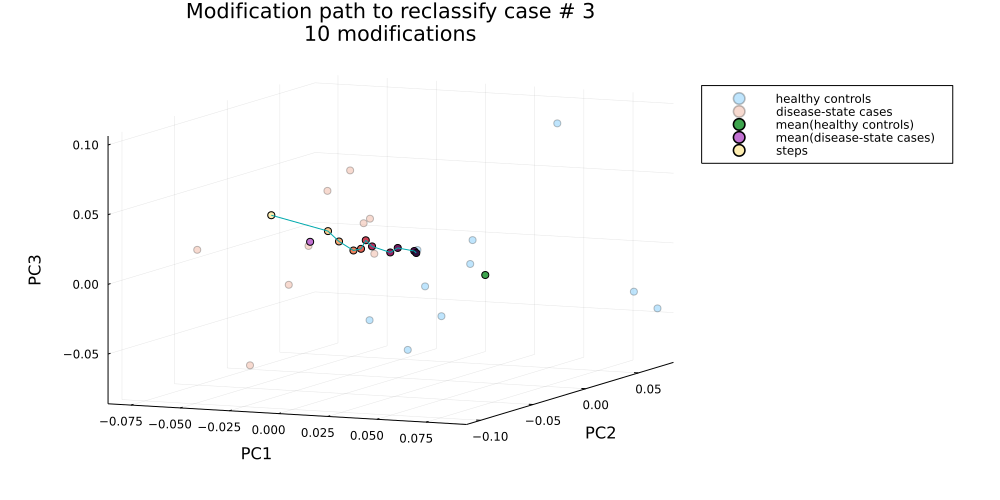

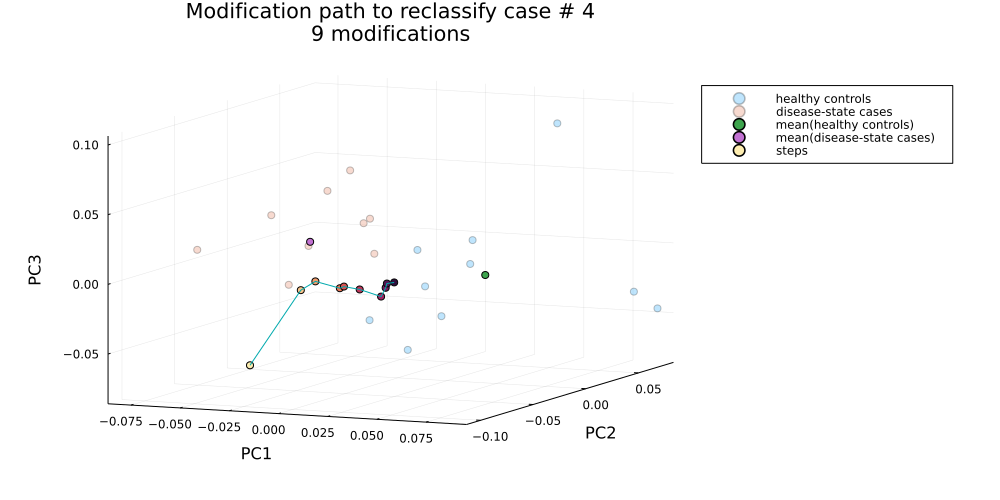

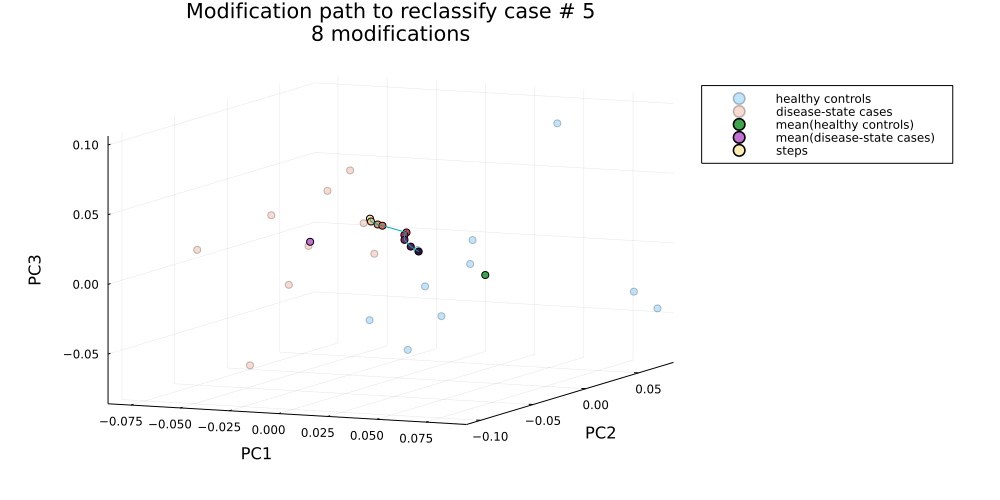

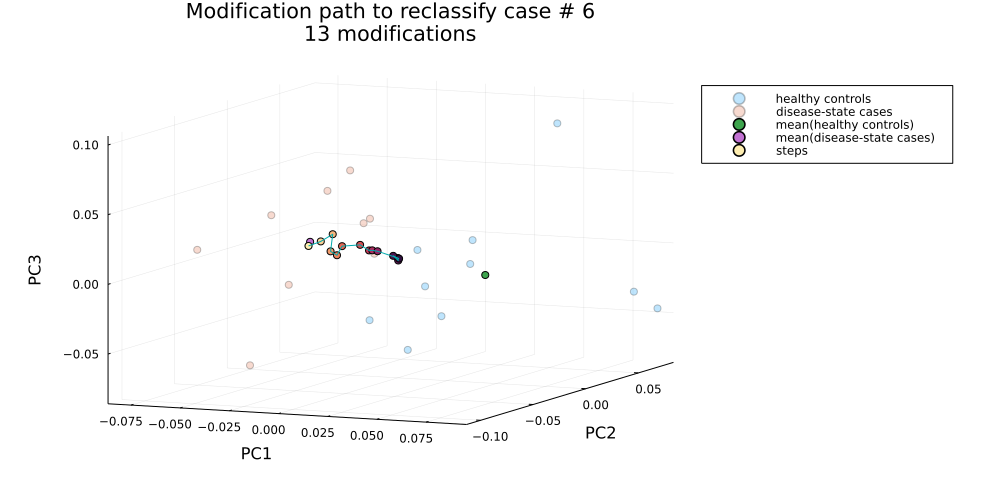

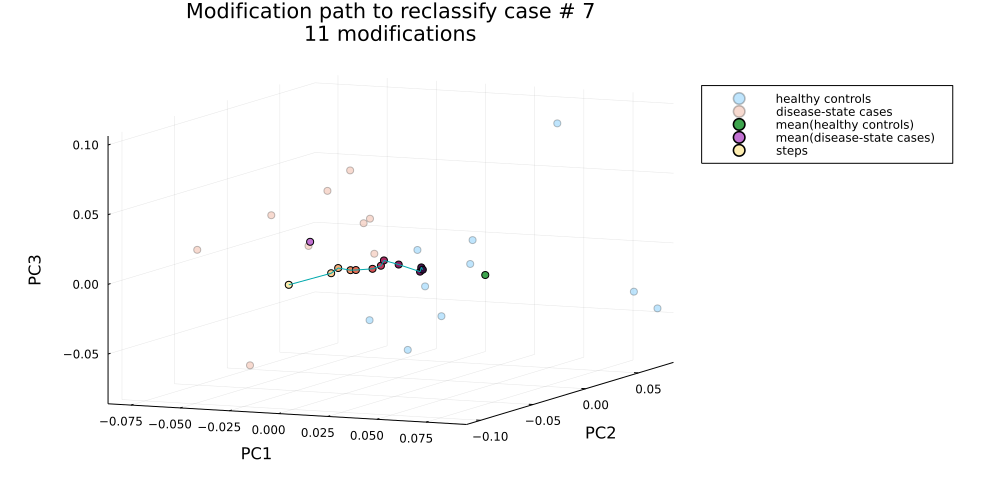

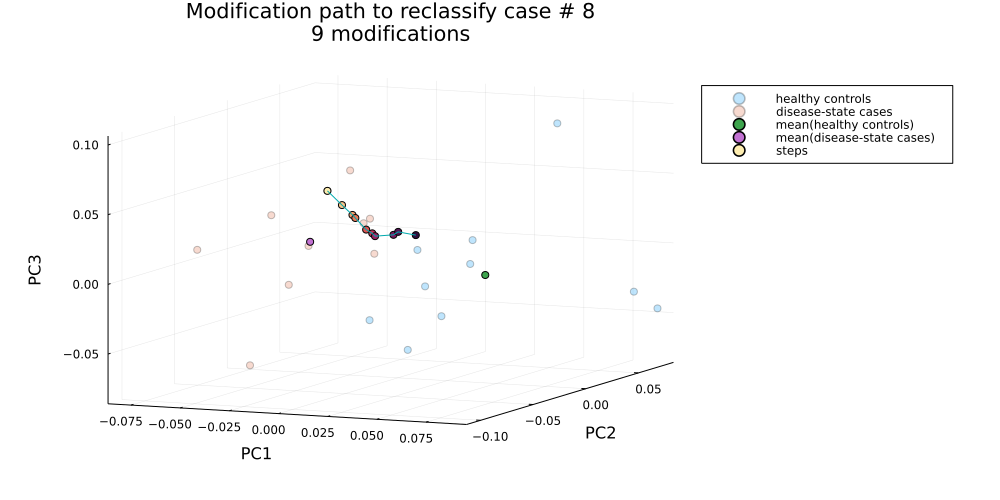

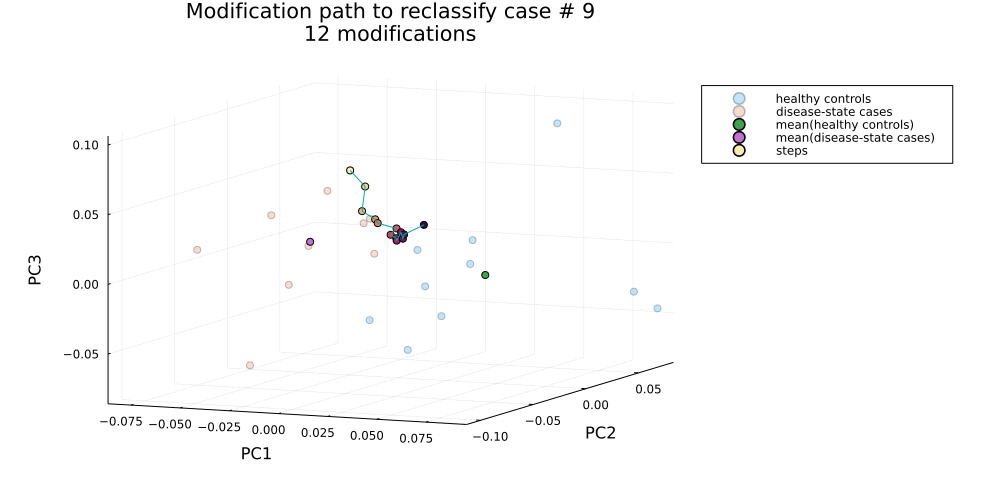

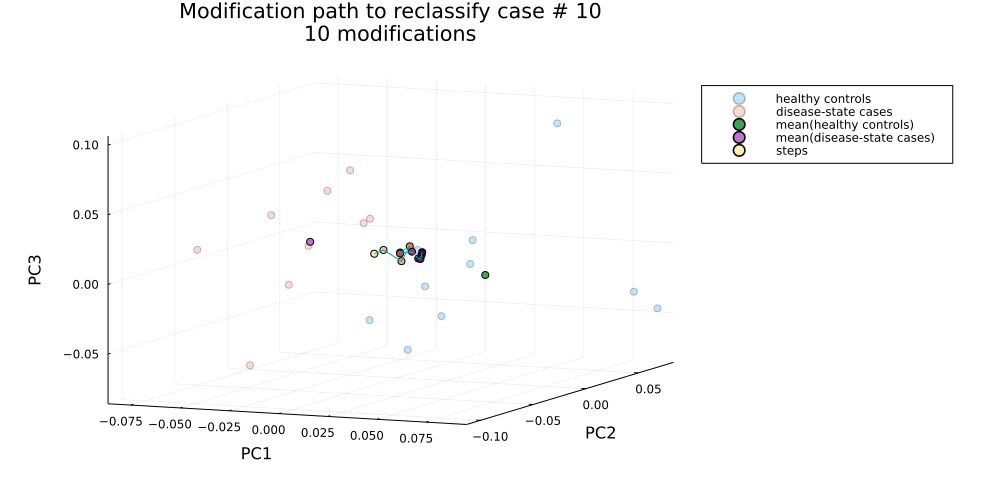

In [6]:
for outlier_index in samples_per_group+1:samples_per_group * number_of_groups
    outlier_observation = observations[:, outlier_index]
    outlier_observation_updates = []
    for i in 1:length(outlier_observation)
        if i == 1
            modified_observation = copy(outlier_observation)
        else
            modified_observation = copy(last(outlier_observation_updates))
        end
        transformed_modified_observation = MultivariateStats.transform(pca_model, modified_observation)
        current_distance = Distances.euclidean(transformed_modified_observation, mean_of_transformed_controls)
        best_change_index = 0
        for j in 1:length(modified_observation)
            candidate_observation = copy(modified_observation)
            candidate_observation[j] = reconstructed_mean_of_controls[j]
            transformed_candidate_observation = MultivariateStats.transform(pca_model, candidate_observation)
            distance_to_mean_of_transformed_controls = Distances.euclidean(transformed_candidate_observation, mean_of_transformed_controls)
            if distance_to_mean_of_transformed_controls < current_distance
                current_distance = distance_to_mean_of_transformed_controls
                best_change_index = j
            end
        end
        modified_observation[best_change_index] = reconstructed_mean_of_controls[best_change_index]
        push!(outlier_observation_updates, modified_observation)
        transformed_modified_observation = MultivariateStats.transform(pca_model, modified_observation)
        distance_to_mean_controls = Distances.euclidean(transformed_modified_observation, mean_of_transformed_controls)
        distance_to_mean_cases = Distances.euclidean(transformed_modified_observation, mean_of_transformed_cases)
        if distance_to_mean_controls < distance_to_mean_cases
    #         @show "done!", i
            # we're now more similar to the controls than to the cases
            break
        end
    end
    # updated_observations

    updates_plot = 
    StatsPlots.scatter(
        pc3_plot,
        [x[outlier_index], [MultivariateStats.transform(pca_model, x)[1] for x in outlier_observation_updates]...],
        [y[outlier_index], [MultivariateStats.transform(pca_model, x)[2] for x in outlier_observation_updates]...],
        [z[outlier_index], [MultivariateStats.transform(pca_model, x)[3] for x in outlier_observation_updates]...],
        labels = "steps",
        color = collect(StatsPlots.cgrad(:matter, length(outlier_observation_updates) + 1, categorical = true)),
        title = "Modification path to reclassify case # $(outlier_index - samples_per_group)\n$(length(outlier_observation_updates)) modifications"
    )
    
    updates_plot = 
    StatsPlots.plot(
        updates_plot,
        [x[outlier_index], [MultivariateStats.transform(pca_model, x)[1] for x in outlier_observation_updates]...],
        [y[outlier_index], [MultivariateStats.transform(pca_model, x)[2] for x in outlier_observation_updates]...],
        [z[outlier_index], [MultivariateStats.transform(pca_model, x)[3] for x in outlier_observation_updates]...],
        labels = "",
    )

    display(updates_plot)
end